# Knowledge Survival Model
## Lindy Effect / Pareto Model
- $S(t)=qS_\text{Lindy}(t)+(1-q)S_\text{Jump}(t)$
  - Jump handles "big-bang" epistemic resets.
  - $S_\text{Jump}$ seems like the emergence of a competing truth.
  - Draw the *life-length* $\tau$ from this mixture $S(t)$ once, at $t=0$
    - $I_t=
          \begin{cases}
              1, t<\tau\\
              0, t\ge\tau
          \end {cases}$
  - $S(t)$ measures two thresholds:
    - **Truth collapse threshold** $\theta_\text{truth}$ (e.g., $T_t \le 0.1$)
    - **Utility collapse threshold** $\theta_\text{util}$ (e.g., $U_t \le 0.05 \times U_0$)
    - $\tau$ is the first hitting time of either threshold or an exogenous paradigm-shifting event.
      - The empirical $S(t)$ then becomes the survival curve of "value above minimal relevance."
      - In practice:
        - Simulate $T_t$ and $U_t$
        - Set $\tau = \text{inf}\{t:T_t\le\theta_\text{truth} \text{ or } U_t\le\theta_\text{util}\}$
    - Estimate $S(t)$ non-parametrically from historical citation-decay data and then blend Lindy tails for the far relevance horizon.

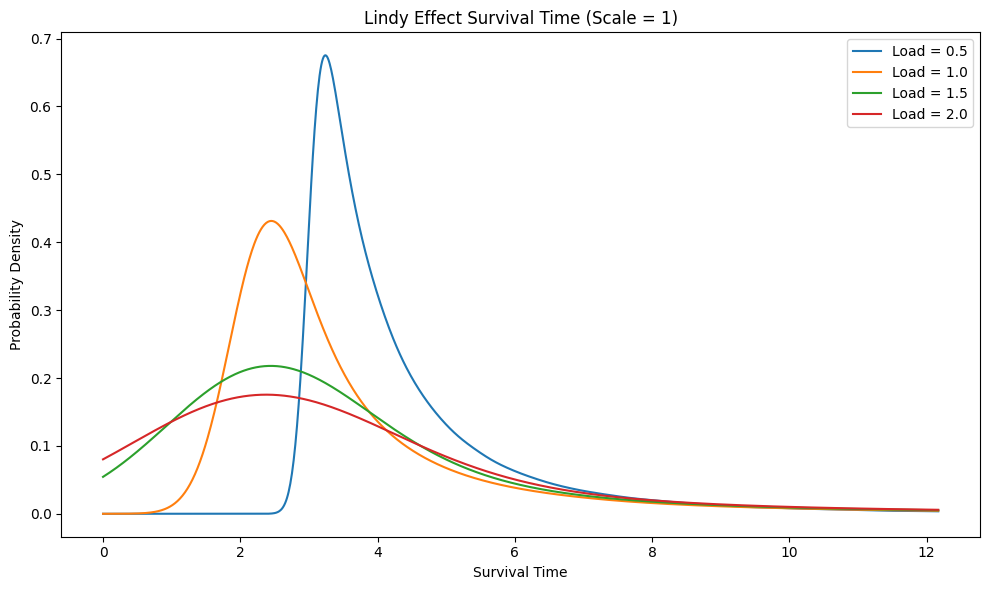

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pareto


# Generate Lindy Effect Survival data
def generate_lindy_effect_data(n_sims=10_000, load=1, scale=1):
    scale = (1+load)/load

    # Generate Pareto-distributed data
    data = pareto.rvs(scale, size=n_sims, scale=scale)
    
    # # Create a DataFrame to hold the data
    # df = pd.DataFrame(data, columns=['Survival Time'])
    
    # # Calculate the Lindy Effect (logarithm of survival time)
    # df['Lindy Effect'] = np.log(df['Survival Time'])
    
    return data

n_sims = 100_0000

# Simulate Linde Effect
truth_param_list = [0.5, 1.0, 1.5, 2.0]
lindy_sims = [generate_lindy_effect_data(n_sims=n_sims, load=load) for load in truth_param_list]
density_list = [stats.gaussian_kde(sim) for sim in lindy_sims]

# Plot the Lindy Effect Survival data
plt.figure(figsize=(10, 6))
x = np.linspace(0, max([np.percentile(sim, 95) * 1.1 for sim in lindy_sims]), 1000)
for idx, load in enumerate(truth_param_list):
    plt.plot(x, density_list[idx](x), label=f'Load = {load}')
plt.legend(loc='best')
plt.title('Lindy Effect Survival Time (Scale = 1)')
plt.xlabel('Survival Time')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.show()


## Modeling Decay/Distortion
- "Deterioration + shock" framework
- Components:
  - Erosion (slow blur of knowledge)
    - Erosion $D_t$ is Gamma with mean drift $\alpha t$
  - Recovery (restoration)
  - Shocks (misinformation events)
    - Compound Negative Binomial $\sum_{i=1}^{N_t}Z_i$ where $Z_i \sim \text{Lognormal/Pareto}$
- Truth level $T_t \sim e^{-D_t+\text{Recovery}_t-J_t}$ clipped at $[0, 1]$.
  - $J_t=\sum_i^{N_t} Z_i$ where $N_t\sim \text{NegBin}(\lambda t)$ representing misinformation shocks.
    - $N_t$ will be modeled as discrete annual shocks

### Monthly Truth Level Simulation

annual: 0.6377326874018597 annualized monthly: 0.6322241621049087


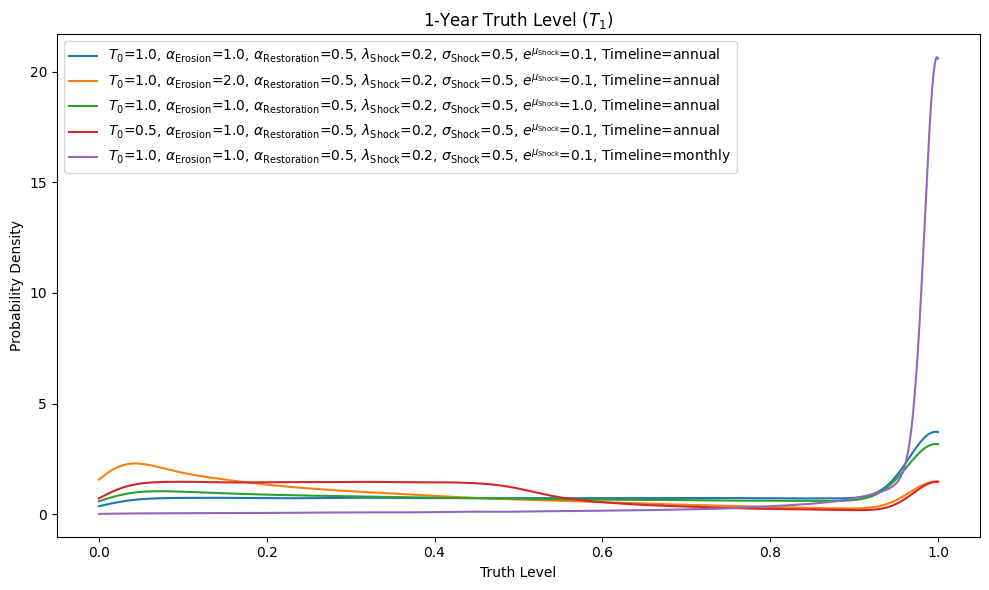

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import gamma, nbinom, lognorm


truth_level_params = [r"$T_0$",
                    r"$\alpha_\text{Erosion}$",
                    r"$\alpha_\text{Restoration}$",
                    r"$\lambda_\text{Shock}$",
                    r"$\sigma_\text{Shock}$",
                    r"$e^{\mu_\text{Shock}}$",
                    r"Timeline"]


def sim_truth_level(
        starting_truth,
        erosion_shape,
        restoration_shape,
        shock_lambda,
        shock_sigma,
        shock_scale,
        timeline='annual',  # can be 'annual' or 'monthly'
        n_sims=10_000
):
    """
    Simulate the Truth Level of knowledge over time using a combination of erosion, restoration, and shock events.

    Parameters:
    - starting_truth: Initial truth level (0 to 1).
    - erosion_shape: Shape parameter for the gamma distribution representing erosion.
    - restoration_shape: Shape parameter for the gamma distribution representing restoration.
    - shock_r: Shock frequency input (Negative Binomial distribution parameter r).
    - shock_p: Shock frequency input (Negative Binomial distribution parameter p).
    - shock_sigma: Standard deviation of the log-normal distribution representing shock severity.
    - shock_scale: Scale parameter of the log-normal distribution representing shock severity.
    - timeline: 'annual' or 'monthly' to indicate the simulation time frame.
    - n_sims: Number of simulations to run.


    Returns:
    - truth_level: Simulated truth level after the specified time period.


    Notes:
    - Parameters must be supplied annualized, even when running monthly simulations.
    """
    if timeline not in ['annual', 'monthly']:
        raise ValueError("Timeline must be either 'annual' or 'monthly'.")

    if timeline == 'annual':
        # Simulate truth drift using a gamma distribution
        erosion_shape = gamma.rvs(erosion_shape, scale=1.0, size=n_sims)

        # Simulate the restoration rate using a gamma distribution
        recovery_rate = gamma.rvs(restoration_shape, scale=1.0, size=n_sims)

        # Simulate the number of shocks using a poisson distribution
        annual_shocks = stats.poisson.rvs(shock_lambda, size=n_sims)

        max_shocks = int(annual_shocks.max())
        shock_event_idx = np.arange(max_shocks)
        shock_event_mask = shock_event_idx[None, :] < annual_shocks[:, None]

        # Simulate the amount of shocks using a log-normal distribution
        shock_severities = lognorm.rvs(
            shock_sigma, scale=shock_scale, size=(n_sims, max_shocks))
        total_shocks = np.zeros((n_sims, max_shocks))
        total_shocks[shock_event_mask] = shock_severities[shock_event_mask]
        total_shock_rate = total_shocks.sum(axis=1)

        # Combine the effects
        truth_level = starting_truth * \
            np.exp(-erosion_shape + recovery_rate - total_shock_rate)

        # Ensure the truth level is between 0 and 1
        truth_level = np.clip(truth_level, 0.0, 1.0)

        return truth_level
    elif timeline == 'monthly':
        # Simulate truth drift using a gamma distribution
        erosion_shape = gamma.rvs(erosion_shape / 12.0, scale=1.0, size=n_sims)

        # Simulate the restoration rate using a gamma distribution
        recovery_rate = gamma.rvs(
            restoration_shape / 12.0, scale=1.0, size=n_sims)

        # true Poisson thinning for shocks
        monthly_lambda = shock_lambda * (1.0 / 12.0)
        monthly_shocks = stats.poisson.rvs(monthly_lambda, size=n_sims)

        if monthly_shocks.size == 0:
            total_shock_rate = 0
        else:
            max_shocks = int(monthly_shocks.max())
            shock_event_idx = np.arange(max_shocks)
            shock_event_mask = shock_event_idx[None, :] < monthly_shocks[:, None]

            # Simulate the amount of shocks using a log-normal distribution
            shock_severities = lognorm.rvs(
                shock_sigma, scale=shock_scale, size=(n_sims, max_shocks))
            total_shocks = np.zeros((n_sims, max_shocks))
            total_shocks[shock_event_mask] = shock_severities[shock_event_mask]
            total_shock_rate = total_shocks.sum(axis=1)

        # Combine the effects
        truth_level = starting_truth * \
            np.exp(-erosion_shape + recovery_rate - total_shock_rate)

        # Ensure the truth level is between 0 and 1
        truth_level = np.clip(truth_level, 0.0, 1.0)

        return truth_level
    else:
        raise ValueError("Timeline must be either 'annual' or 'monthly'.")


n_sims = 100_000

truth_params_list = [(1.0, 1.0, 0.5, 0.2, 0.5, 0.1, 'annual'),
                    (1.0, 2.0, 0.5, 0.2, 0.5, 0.1, 'annual'),
                    (1.0, 1.0, 0.5, 0.2, 0.5, 1.0, 'annual'),
                    (0.5, 1.0, 0.5, 0.2, 0.5, 0.1, 'annual'),
                    (1.0, 1.0, 0.5, 0.2, 0.5, 0.1, 'monthly')]

# Simulate Truth Level
truth_level_sims = [sim_truth_level(*params, n_sims=n_sims)
                    for params in truth_params_list]
truth_level_kde_list = [stats.gaussian_kde(sim) for sim in truth_level_sims]

mean_monthly_truth_level = 1.0
for mo in range(1, 13):
    monthly_sim = sim_truth_level(
        mean_monthly_truth_level, 1.0, 0.5, 0.2, 0.5, 0.1, 'monthly', n_sims=n_sims)
    mean_monthly_truth_level = monthly_sim.mean()

print('annual:', truth_level_sims[0].mean(),
        'annualized monthly:', mean_monthly_truth_level)

# Plot the Truth Level simulation data
plt.figure(figsize=(10, 6))
x = np.linspace(0.0, 1.0, 1000)
for idx, truth_level_dist in enumerate(truth_level_kde_list):
    param_label = ", ".join([f'{truth_level_params[param]}={truth_params_list[idx][param]}' for param in range(
        len(truth_params_list[idx]))])
    plt.plot(x, truth_level_dist(x), label=param_label)
plt.legend(loc='best')
plt.title('1-Year Truth Level ($T_1$)')
plt.xlabel('Truth Level')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.show()

## Utility & Value
- $V_t=I_t\times U_t\times T_t\times R_t$
  - $V_t$ = Value of knowledge
  - $I_t$ = binary survival of the idea, defined above, measured using $S(t)$
    - $1$ or $0$
  - $U_t$ = Usefulness, maybe a mean-reverting process reflecting how often the knowledge is referenced in decisions.
    - $\ge0$
    - $U_t=\alpha\text{CiteVel}_t+\beta\text{SearchHits}_t$
      - Citation velocity via arXiv / CrossRef API (monthly new citations).
        - Similarly monthly search hits
      - Maybe add down-trend factor when newer competing papers appear.
    - Model as **Ornstein-Uhlenbeck:**
      - $dU_t=\kappa(\bar{U}-U_t)dt+\sigma_U dW_t$
        - mean level $\bar{U}$ itself can drift downward if $T_t$ falls sharply (credibility drag)
  - $T_t$ = Truth level, as above.
    - $\in[0, 1]$
  - $R_t$ = Replaceability (cost to re-learn).
    - $>0$
    - $(0,1)$ for easy
    - $1$ for baseline
    - $>1$ for hard
- Net Present-Value: $\text{NPV} = \int_0^\infty e^{-rt}V_tdt$
  - Exposure base for the Premium

### Utility Model
- Model as **Ornstein-Uhlenbeck:**
    - $dU_t=\kappa(\bar{U}-U_t)dt+\sigma_U dW_t$
    - mean level $\bar{U}$ itself can drift downward if $T_t$ falls sharply (credibility drag)
    - This process at any $t$ is normal with:
      - $\mathbb{E}[U_t]=\bar{U}+(U_0 - \bar{U})e^{-\kappa t}$
      - $\text{Var}[U_t]=\frac{\sigma^2_U}{2\kappa}(1-e^{-2\kappa t})$

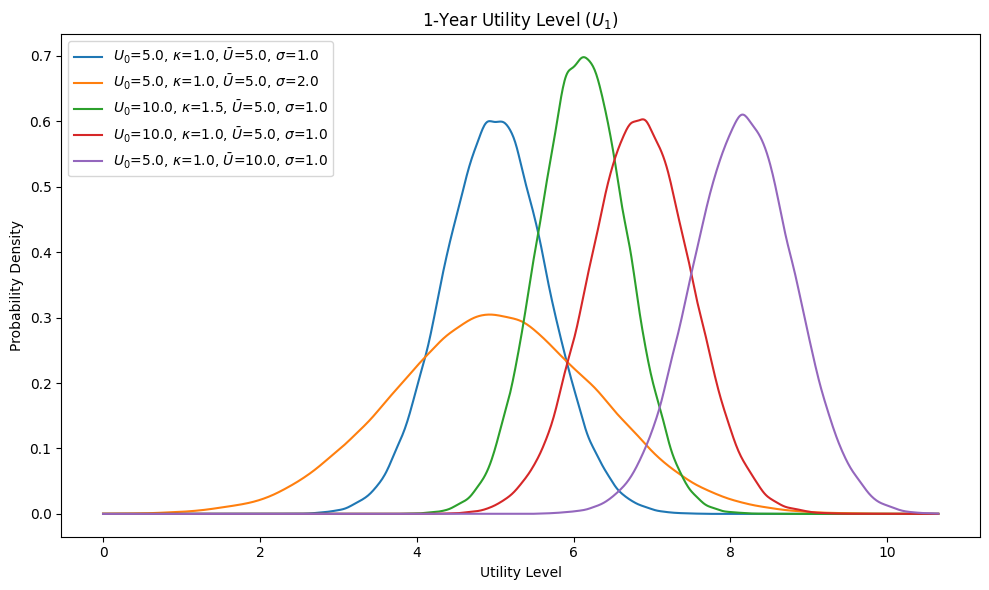

In [3]:
util_level_params = [r"$U_0$", 
                    r"$\kappa$", 
                    r"$\bar{U}$", 
                    r"$\sigma$"]

def sim_util(
        U0,          # starting value
        kappa,         # mean-reversion speed
        U_bar,         # long-run mean
        sigma,         # volatility
        t = 1.0,       # horizon (year)
        n_sims=10_000  # Monte-Carlo draws
):
    """
    Simulate the Utility Level of knowledge over time using a mean-reverting process.
    Implements the Ornstein-Uhlenbeck process.

    
    Parameters:
    - U0: Initial utility level (0 to 1).
    - kappa: Mean-reversion speed (0 to 1).
    - U_bar: Long-run mean utility level (0 to 1).
    - sigma: Volatility of the utility level (0 to 1).
    - t: Time horizon (in years).
    - n_sims: Number of simulations to run.


    Returns:
    - Ut_dist: Simulated utility level after the specified time period.
    """
    theoretical_mean = U_bar + (U0 - U_bar) * np.exp(-kappa * t)
    theoretical_var = sigma ** 2 / (2 * kappa) * (1 - np.exp(-2 * kappa * t))
    Ut_dist = stats.norm.rvs(loc=theoretical_mean, scale=np.sqrt(theoretical_var), size=n_sims)
    return Ut_dist

n_sims = 100_000

util_params_list = [(5.0, 1.0, 5.0, 1.0),
                    (5.0, 1.0, 5.0, 2.0),
                    (10.0, 1.5, 5.0, 1.0),
                    (10.0, 1.0, 5.0, 1.0),
                    (5.0, 1.0, 10.0, 1.0)]

# Simulate Truth Level
util_level_sims = [sim_util(*params, n_sims=n_sims) for params in util_params_list]
util_level_kde_list = [stats.gaussian_kde(sim) for sim in util_level_sims]

# Plot the Utility simulation data
plt.figure(figsize=(10, 6))
x = np.linspace(0, max([np.percentile(sim, 99) * 1.1 for sim in util_level_sims]), 1000)
for idx, util_level_dist in enumerate(util_level_kde_list):
    param_label = ", ".join([f'{util_level_params[param]}={util_params_list[idx][param]}' for param in range(len(util_params_list[idx]))])
    plt.plot(x, util_level_dist(x), label=param_label)
plt.legend(loc='best')
plt.title('1-Year Utility Level ($U_1$)')
plt.xlabel('Utility Level')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.show()

### Calculate Net Present-Value
- $\text{NPV} = \int_0^\infty e^{-rt}V_tdt$
  - Exposure base for the Premium

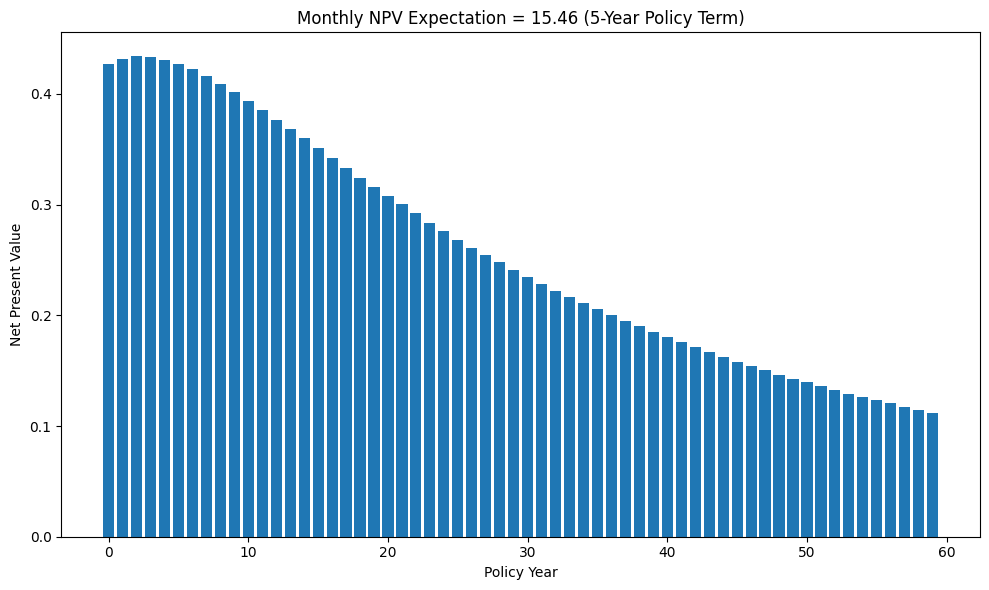

In [ ]:
def calculate_value(
    utility_params,  # Utility parameters (U0, kappa, U_bar, sigma)
    starting_truth,  # Starting truth level (T0)
    # Truth parameters (T0, alpha_erosion, alpha_restoration, r_shock, p_shock, sigma_shock, scale_shock)
    truth_params,
    replaceability=1.0,  # Cost to re-learn (1.0 is baseline, >1 is hard)
    years=5,  # Time horizon (in integer years)
    n_sims=10_000  # Number of Monte Carlo simulations
):
    """
    Calculate the value over time V_t of a covered piece of knowledge.
    This serves as the policy exposure.

    Returns:
    - monthly_all: shape (years * 12, n_sims) of all sim paths
    """
    n_months = years * 12
    dt = 1 / 12.0

    # initialize arrays to track simulations
    util = np.full(n_sims, utility_params[0])
    truth = np.full(n_sims, starting_truth)

    # pre-allocate
    monthly_all = np.zeros((n_months, n_sims))

    # unpack
    _, kappa, U_bar, sigma = utility_params

    for month in range(n_months):
        # OU step for U
        dW = np.random.randn(n_sims) * np.sqrt(dt)
        util += kappa * (U_bar - util) * dt + sigma * dW

        # truth step
        truth = sim_truth_level(
            truth,
            *truth_params,
            timeline='monthly',
            n_sims=n_sims
        )

        # track NPV for each sim
        monthly_all[month] = util * truth * replaceability * dt

    # average across sims
    monthly_mean = monthly_all.mean(axis=1)
    return monthly_all

def calculate_exposure(
    discount_rate,  # Discount rate
    utility_params,  # Utility parameters (U0, kappa, U_bar, sigma)
    starting_truth,  # Starting truth level (T0)
    # Truth parameters (T0, alpha_erosion, alpha_restoration, r_shock, p_shock, sigma_shock, scale_shock)
    truth_params,
    replaceability=1.0,  # Cost to re-learn (1.0 is baseline, >1 is hard)
    years=5,  # Time horizon (in integer years)
    n_sims=10_000  # Number of Monte Carlo simulations
):
    """
    Calculate the Net Present Value (NPV) of a covered piece of knowledge.
    This serves as the policy exposure.

    Returns:
    - monthly_mean: average NPV per month (length years * 12)
    - monthly_all: shape (years * 12, n_sims) of all sim paths
    """
    n_months = years * 12
    dt = 1 / 12.0

    monthly_all_undiscounted = calculate_value(
        utility_params=utility_params, 
        starting_truth=starting_truth,
        truth_params=truth_params,
        replaceability=replaceability,
        years=years,
        n_sims=n_sims)

    monthly_all_discounted = np.zeros(monthly_all_undiscounted.shape)
    for month in range(n_months):
        # track NPV for each sim
        monthly_discount_rate = (1 + discount_rate) ** (month * dt)
        monthly_all_discounted[month] = monthly_all_undiscounted[month] / monthly_discount_rate

    # average across sims
    monthly_mean = monthly_all_discounted.mean(axis=1)
    return monthly_mean, monthly_all_discounted


discount_rate = 0.045
utility_params = [5.0, 1.0, 10.0, 1.0]
starting_truth = 1.0
truth_params = [1.0, 0.5, 0.2, 0.5, 0.1]
replaceability = 1.0
policy_duration = 5  # years
n_sims = 100_000

monthly_mean, monthly_npv_list = calculate_exposure(discount_rate,
                                                    utility_params,
                                                    starting_truth,
                                                    truth_params,
                                                    replaceability,
                                                    policy_duration,
                                                    n_sims=n_sims)

x = range(policy_duration * 12)

# Plot the NPV expectation data
plt.figure(figsize=(10, 6))
plt.bar(x, monthly_mean)
# plt.legend(loc='best')
plt.title(f'Monthly NPV Expectation = {sum(monthly_mean):,.2f} ({policy_duration}-Year Policy Term)')
plt.xlabel('Policy Year')
plt.ylabel('Net Present Value')
plt.tight_layout()
plt.show()

## Portfolio Effects
- Tail dependence using copulas, Gumbel
- Selection bias - insureds may only buy cover on dubious knowledge, so we have anti-selection.
  - Underwriting questions?

## Product Design Ideas
- Verification Costs ~ "First-party loss", pays for replication studies, fact-checking reviews. Frequency is high, severity mid.
- Decision Error Liability ~ "E&O cover", third-party liability when bad knowledge causes client harm. Low frequency, fat-tail severity.
- Depreciation guarantee ~ "Depreciation stop-loss". If NPV of knowledge drops > X% within Y years, indemnify. Parametric trigger using agreed NPV index.
  - Retention/deductible expressed as an *evidence budget* the insured must spend before claiming indemnity.

## Focus: Knowledge Depreciation Guarantee (KDG)
- Parametric

### Trigger Design
- **Index:** rolling NPV of $V_t$ (or a simpler $U\times T$ index)
- **Strike:** e.g., 30% drop from baseline within a three-year window.
  - **So the policy duration will be about 5 years.**
- **Waiting period / excess:** the policyholder must self-fund the first X% of loss or spend $Y on verification attempts before claiming restitution.

In [ ]:
def kdg_loss(
        
)

### Pricing Flow
- **Exposure base:** initial index value $V_0$ or average over first quarter.
- **Loss distribution:** run Monte-Carlo on the full coupled system $(I, T, U)$ to get annual loss $L$.
- **Pure Premium:** $\mathbb{E}[L|\text{deductible, limit}]$
- **Risk Load:** $\text{TVaR}_{99\%}+\text{parametric risk on }\lambda, \alpha,\text{ etc.}$
- **Capital Cost:** $\text{CoC}\times \text{SCR (1-in-200 depreciation event)}$

### Moral Hazard Levers
- **Parametric recoveries:** Payout is automatic when index hits strike; reduces disputes but forces transparent index constrction.
- **Evidence maintenance clause:** Require periodic replication or citation-audit. Non-compliance raises deductible.
- **Experience rating:** Post-loss surcharge on future premium if insured's own corrections lagged.
- **Co-insurance on *truth recovery* costs:** Insured shares 20-30% of replication spend to get skin in the game.
- **Real-time monitoring:** Pull citation velocity directly; premium credits for upward trends.

## Pricing Sketch ("Actuarial Cost of Truth")
- Exposure base: $\mathbb{E}[\text{NPV}]$.
- Frequency-Severity simulation of decay & shocks to get an annual loss distribution per $1 NPV.
- Risk load:
  - **Parametric Risk:** Baysian posterior on $p, \alpha, \lambda, \text{etc.}$, add a credibility margin.
  - **Model risk:** Stress alternate decau regimes (paradigm shift) and take Tail-VaR (e.g., 99.5th percentile).
- **Cost of Capital:** CoC * SCR (Solvency II-style). For intellectual assets, let SCR be driven by 1-in-200 utility collapse.
- **Premium:** $\text{Pure Premium}+\text{Risk Load}+\text{Expense}+\text{Profit}$.
  - $\Pi=\mathbb{E}[L]+k\text{TVaR}_{99.5\%}(L)+\text{Exp}+\text{Profit}$
  - $L$=simulated loss ratio.
  - $k\approx$ weighted average cost of capital.

## Implementation Sketch

1. Select corpus (DOI / arXiv IDs list) peer-reviewed
2. Baseline measurement
   - $U_0$ = citation_velocity(start)
   - $T_0$ = 1 (assumed peer-reviewed)
   - $V_0 = U_0\times T_0$
3. Monthly update loop:
   1. Pull new citations $\Delta U$
   2. Scrape retraction / erratum databases, shock arrivals $Z_i$
   3. Update $U_t$ via OU step
   4. Udate $D_t, J_t, \text{Recovery}_t$
   5. Compute $V_t=I_t\times U_t\times T_t$
   6. Check depreciation trigger
4. Premium refresh annually(?) with credibility-weighted posterior on $(\lambda,\kappa,\sigma_\text{U},\alpha_\text{drift},...)$.
   - Is this annually or every 5 years?

## Roadmap Post-Implementation
- **Calibrate U-process** from a sample of arXiv categories to get $\kappa$ and $\sigma_U$
- **Estimate shock severity** distribution Z from Retraction Watch data (lognormal heavy tail fits nicely).
- **Blend survival:** fit Kaplan-Meier to "time-to-major-revision" for textbooks or RFCs, then add a Pareto tail for the beyond-data horizon.
- **Prototype pricing:** small Python Month-Carlo for a single article's KDG with 30% trigger, 10% deductible, USD $1M limit.